In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import seaborn
seaborn.set()

### Node class

In [2]:
class Node:
    
    def __init__(self, gini=None, feature_index=None, threshold=None, left=None, right=None, prediction=None):
        self.gini = gini
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.prediction = prediction

### Tree class

In [3]:
class MyDecisionTreeClassifier:
    
    def __init__(self, max_depth, entropy=False):
        self.max_depth = max_depth
        self.root = None
        self.entropy = entropy
    
    def split_data(self, data, f_index, threshold):
        """
        Splits data into 2 array by comparing f_index column values to threshold
        """
        left = np.array([row for row in data if row[f_index]<threshold])
        right = np.array([row for row in data if row[f_index]>=threshold])
        return left, right
    
    def gini(self, y):
        """
        Calculates gini or entropy of one split 
        """
        labels = np.unique(y)
        gini = 0
        if not self.entropy:
            for label in labels:
                gini += (len(y[y==label]) / len(y)) ** 2
            return 1 - gini
        else:
            for label in labels:
                gini -= np.log2(len(y[y==label]) / len(y))
                return gini
    
    def gini_impurity(self, parent, left_leaf, right_leaf):
        """
        Calculates gini impurity of parent and chaildrens
        """
        weight_left = len(left_leaf)/len(parent)
        weight_right = len(right_leaf)/len(parent)
        gain = weight_left*self.gini(left_leaf) + weight_right*self.gini(right_leaf)
        return gain
    
    def split_data_with_gini(self, data):
        """
        Find the best split based on gini
        """
        X, y = data[:, :-1], data[:, -1].astype(np.int)
        n_features = X.shape[-1]
        min_gini = np.inf
        info = {}
        if len(np.unique(y))==1:
            return "It's a leaf!"
        for f_index in range(n_features):
            values = X[:, f_index]
            possible_threshholds = np.unique(values)
            for threshhold in possible_threshholds:
                data_left, data_right = self.split_data(data, f_index, threshhold)
                if data_left.any() and data_right.any():
                    y_left, y_right = data_left[:, -1], data_right[:, -1]
                    curr_gini = self.gini_impurity(y, y_left, y_right)
                    if curr_gini<min_gini:
                        min_gini = curr_gini
                        info["best_threshhold"] = threshhold
                        info["gini"] = curr_gini
                        info["data_right"] = data_right
                        info["data_left"] = data_left
                        info["f_index"] = f_index
        return info

    def leaf_prediction(slef, y):
        """
        Calculates leaf prediction value
        """
        values, counts = np.unique(y, return_counts=True)
        ind = np.argmax(counts)
        
        return values[ind]
    
    def build_tree(self, dataset, curr_depth = 0, max_depth=3):
        """
        Build a tree.
        Finds the best split and return a Node class with threshold, 
        """
        X, y = dataset[:, :-1], dataset[:, -1].astype(np.int)
        n_samples, n_features = np.shape(X)
        if curr_depth<max_depth:
            best_split = self.split_data_with_gini(dataset)
            if best_split=="It's a leaf!":
                prediction = self.leaf_prediction(y)
                return Node(prediction=prediction)
            if best_split["gini"] > 0:
                left_leaf = self.build_tree(best_split["data_left"], curr_depth+1, max_depth=self.max_depth)
                right_leaf = self.build_tree(best_split["data_right"], curr_depth+1, max_depth=self.max_depth)
                return Node(best_split["gini"], best_split["f_index"], 
                            best_split["best_threshhold"], left_leaf, right_leaf)

        prediction = self.leaf_prediction(y)
        return Node(prediction=prediction)

    
    def fit(self, X, y):
        """
        Fits the data to tree
        """
        data = np.hstack((X, y.reshape(-1, 1)))
        self.root = self.build_tree(data, max_depth=self.max_depth)
    
    def predict_one_sample(self, X_test, node):
        """
        Makes a prediction on one sample
        """
        if node.prediction!=None: return node.prediction
        to_check = X_test[node.feature_index]
        if to_check < node.threshold:
            return self.predict_one_sample(X_test, node.left)
        else:
            return self.predict_one_sample(X_test, node.right)
        
    def predict(self, X_test):
        """
        Makes prediction on full test dataset
        """
        predictions = [self.predict_one_sample(X_sample, self.root) for X_sample in X_test]
        return predictions


### Load data

In [4]:
iris = load_iris()
X, y = iris.data, iris.target
data = np.hstack((X, y.reshape(-1, 1)))
X.shape, y.shape

((150, 4), (150,))

### Split data in to train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape

((120, 4), (30, 4))

### Fit data to the model

In [6]:
Tree = MyDecisionTreeClassifier(5)
Tree.fit(X_train, y_train)
# with entropy calculations
Tree_log = MyDecisionTreeClassifier(5, entropy=True)
Tree_log.fit(X_train, y_train)

### Prediction example

In [7]:
y_pred = Tree.predict([X[0]])
print("Predicted:", *y_pred)
print("Actual class", y[0])

Predicted: 0
Actual class 0


# Comparing with sklearn model

In [8]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
sum(predictions == y_test) / len(y_test)

0.9666666666666667

### Calculating accurancy

In [9]:
y_pred = Tree.predict(X_test)
print("Tree with normal gini:", sum(y_pred==y_test)/len(y_test))
y_pred_log = Tree_log.predict(X_test)
print("Tree with log gini:", sum(y_pred_log==y_test)/len(y_test))

Tree with normal gini: 0.9333333333333333
Tree with log gini: 0.9666666666666667


## Confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[11  0  0]
 [ 1 11  1]
 [ 0  0  6]]


In [11]:
print("F1 Score:", f1_score(y_test, y_pred, average=None).mean())

F1 Score: 0.9320884429580082


## Comparing accurancy on different size of train/test set

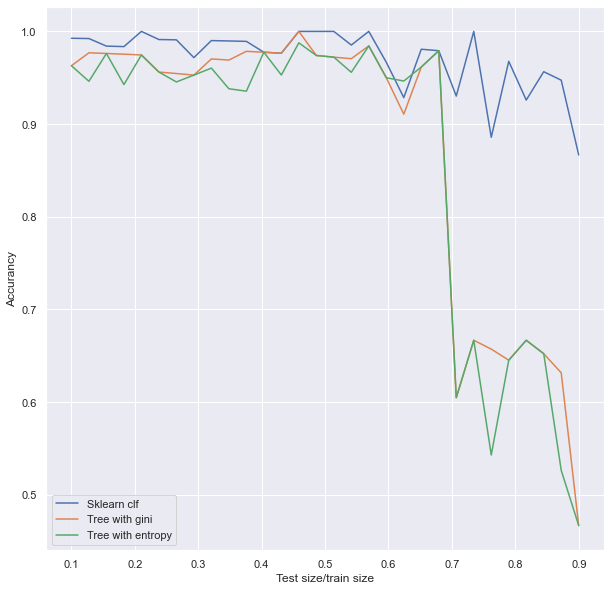

In [22]:
clf_score, tree_score, tree_log_score = list(), list(), list()
from sklearn.model_selection import StratifiedShuffleSplit
for test_size in np.linspace(0.1, 0.9, 30):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    train_index, test_index = list(sss.split(X, y))[0][0], list(sss.split(X, y))[0][0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    Tree = MyDecisionTreeClassifier(5)
    Tree.fit(X_train, y_train)
    Tree_log = MyDecisionTreeClassifier(5, entropy=True)
    Tree_log.fit(X_train, y_train)
    
    clf_pred = clf.predict(X_test)
    clf_score.append(sum(clf_pred==y_test)/len(y_test))
    
    tree_pred = Tree.predict(X_test)
    tree_score.append(sum(tree_pred==y_test)/len(y_test))
    
    tree_log_pred = Tree_log.predict(X_test)
    tree_log_score.append(sum(tree_log_pred==y_test)/len(y_test))

plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0.1, 0.9, 30), clf_score, label="Sklearn clf")
plt.plot(np.linspace(0.1, 0.9, 30), tree_score, label="Tree with gini")
plt.plot(np.linspace(0.1, 0.9, 30), tree_log_score, label="Tree with entropy")
plt.legend()
plt.xlabel("Test size/train size")
plt.ylabel("Accurancy");

Можна поміти, що модель з ентропією справляється трохи гірше, ніж з gini.
Причиною цьому є досить мала вибірка данних

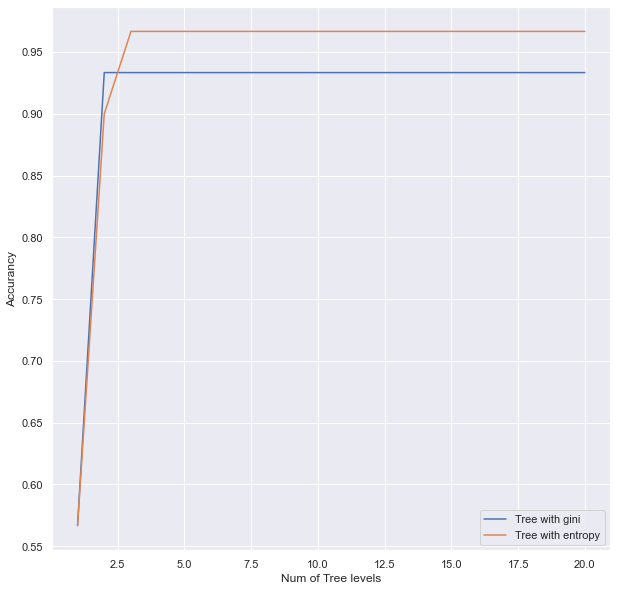

In [14]:
tree_score, tree_log_score = list(), list()
for level in range(1, 21):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    Tree = MyDecisionTreeClassifier(level)
    Tree.fit(X_train, y_train)
    Tree_log = MyDecisionTreeClassifier(level, entropy=True)
    Tree_log.fit(X_train, y_train)
    
    tree_pred = Tree.predict(X_test)
    tree_score.append(sum(tree_pred==y_test)/len(y_test))
    
    tree_log_pred = Tree_log.predict(X_test)
    tree_log_score.append(sum(tree_log_pred==y_test)/len(y_test))

plt.figure(figsize=(10, 10))
plt.plot(list(range(1, 21)), tree_score, label="Tree with gini")
plt.plot(list(range(1, 21)), tree_log_score, label="Tree with entropy")
plt.legend()
plt.xlabel("Num of Tree levels")
plt.ylabel("Accurancy");

Як можна поміти, починаючи з якогось рівня, точність не змінюється

### Cross validation

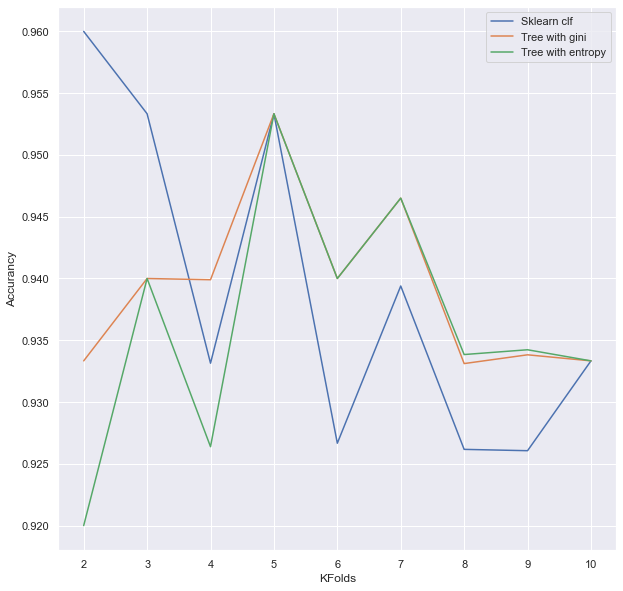

In [199]:
from sklearn.model_selection import StratifiedKFold
clf_score, tree_score, tree_log_score = list(), list(), list()
for fold in range(2, 11):
    clf_cv_score, tree_cv_score, tree_log_cv_score = 0, 0, 0
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = DecisionTreeClassifier()
        clf = clf.fit(X_train, y_train)
        Tree = MyDecisionTreeClassifier(3)
        Tree.fit(X_train, y_train)
        Tree_log = MyDecisionTreeClassifier(3, entropy=True)
        Tree_log.fit(X_train, y_train)
        
        clf_pred = clf.predict(X_test)
        clf_cv_score += sum(clf_pred==y_test)/len(y_test)

        tree_pred = Tree.predict(X_test)
        tree_cv_score += sum(tree_pred==y_test)/len(y_test)

        tree_log_pred = Tree_log.predict(X_test)
        tree_log_cv_score += sum(tree_log_pred==y_test)/len(y_test)
    clf_score.append(clf_cv_score/fold)
    tree_score.append(tree_cv_score/fold)
    tree_log_score.append(tree_log_cv_score/fold)

plt.figure(figsize=(10, 10))
plt.plot(list(range(2, 11)), clf_score, label="Sklearn clf")
plt.plot(list(range(2, 11)), tree_score, label="Tree with gini")
plt.plot(list(range(2, 11)), tree_log_score, label="Tree with entropy")
plt.legend()
plt.xlabel("KFolds")
plt.ylabel("Accurancy");

Як можна побачити, при кросс валідації результати досить задовільні. Різниці між ентропічним деревом і зичайним майже немає.